In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.layers import Dense,Dropout,SimpleRNN
from keras.models import Sequential
from sklearn.metrics import r2_score
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Flatten

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\comp

In [3]:
chunksize = 10**5
chunks = pd.read_csv('D:\\dataset\\Broken_machine\\xtrain.csv',chunksize=chunksize, iterator=True)

X = pd.concat(chunks)

It is already easy to see a bunch of NaN values. And these have to be filled in because simply omitting NaNs dramatically reduces the size of our data.

In [4]:
print('Initial size: {}'.format(X.shape))
print('After NaN omit size: {}'.format(X.dropna().shape))

Initial size: (900000, 58)
After NaN omit size: (2462, 58)


In [5]:
# Check any number of columns with NaN
print(X.isnull().any().sum(), ' / ', len(X.columns))
# Check any number of data points with NaN
print(X.isnull().any(axis=1).sum(), ' / ', len(X))

58  /  58
897538  /  900000


It is impossible to subtract a specific column because NaN is evenly distributed over all columns.

In [7]:
#Lets check where these nulls are.
print (X.isna().sum())
print ('Null to Dataset Ratio in Dates: ',X.isnull().sum()[3]/X.shape[0]*100)

1      79471
2      91079
3      68450
4      71949
5      80625
6     103368
7     108418
8     103595
9      59956
10    105954
11    107911
12     77918
13     98176
14     77109
15    114703
16     77888
17     95691
18     92278
19     42414
20     70401
21     96029
22     86128
23    131388
24     76619
25     90600
26     76446
27    107409
28     87905
29    113008
30     78357
31     72053
32     79065
33     84265
34     84057
35     99034
36     84897
37     68204
38     83217
39     87747
40    113747
41     67152
42     55306
43     79941
44    105538
45     93753
46     79499
47     86376
48     92006
49     96042
50     63239
51    101394
52     56456
53     85983
54     87182
55     99144
56     87074
57     64634
58    113885
dtype: int64
Null to Dataset Ratio in Dates:  7.9943333333333335


In [8]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
0,-42.822536,NaN,12.0,NaN,1.0,2.0,24.0,-45.025510,NaN,1.0,...,17.871210,4.0,15.0,21.863365,-13.349394,-2.215086,-5.137377,20.904186,53.939262,-17.328346
1,-13.478816,13.0,12.0,75.132502,0.0,2.0,24.0,-49.213545,7.0,0.0,...,21.511019,2.0,13.0,-2.880103,21.739125,5.464161,-30.347612,23.304507,47.746225,-47.305489
2,51.702721,13.0,12.0,63.459270,0.0,3.0,24.0,-58.777043,8.0,0.0,...,NaN,3.0,16.0,21.851623,NaN,7.471764,-12.348314,34.406243,34.479515,-33.326172
3,NaN,12.0,13.0,-15.492561,1.0,1.0,23.0,0.624258,9.0,0.0,...,16.964848,2.0,15.0,-25.128119,-26.858262,54.203501,10.341217,29.080753,40.235855,-35.835956
4,7.633273,NaN,13.0,59.862681,0.0,3.0,NaN,-61.395319,NaN,0.0,...,8.467076,4.0,14.0,30.610006,-15.663721,38.323843,-65.561821,33.965883,50.245794,-44.018245


Therefore, we have to fill missing data to avoid unwanted surprises during the models calculation.


Replace NaN with the mean of each column.

In [9]:
cols = X.columns.tolist()

for i in cols:
    col_mean = X[i].mean()
    X[i].fillna(col_mean, inplace = True)

In [10]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
0,-42.822536,12.329729,12.0,25.406132,1.0,2.0,24.000000,-45.025510,7.901558,1.0,...,17.871210,4.0,15.0,21.863365,-13.349394,-2.215086,-5.137377,20.904186,53.939262,-17.328346
1,-13.478816,13.000000,12.0,75.132502,0.0,2.0,24.000000,-49.213545,7.000000,0.0,...,21.511019,2.0,13.0,-2.880103,21.739125,5.464161,-30.347612,23.304507,47.746225,-47.305489
2,51.702721,13.000000,12.0,63.459270,0.0,3.0,24.000000,-58.777043,8.000000,0.0,...,20.596154,3.0,16.0,21.851623,-19.295371,7.471764,-12.348314,34.406243,34.479515,-33.326172
3,11.012513,12.000000,13.0,-15.492561,1.0,1.0,23.000000,0.624258,9.000000,0.0,...,16.964848,2.0,15.0,-25.128119,-26.858262,54.203501,10.341217,29.080753,40.235855,-35.835956
4,7.633273,12.329729,13.0,59.862681,0.0,3.0,23.222268,-61.395319,7.901558,0.0,...,8.467076,4.0,14.0,30.610006,-15.663721,38.323843,-65.561821,33.965883,50.245794,-44.018245


In [11]:
# X = X.fillna(method='bfill').fillna(method='ffill')
# X.head()

In [12]:
chunks = pd.read_csv('D:\\dataset\\Broken_machine\\ytrain.csv',chunksize=chunksize, iterator=True)

y = pd.concat(chunks)

And convert loaded y into array to work with train_test_split function.

In [14]:
y = np.array(y).ravel()

Data distributions
 - Check distribution each columns with histogram

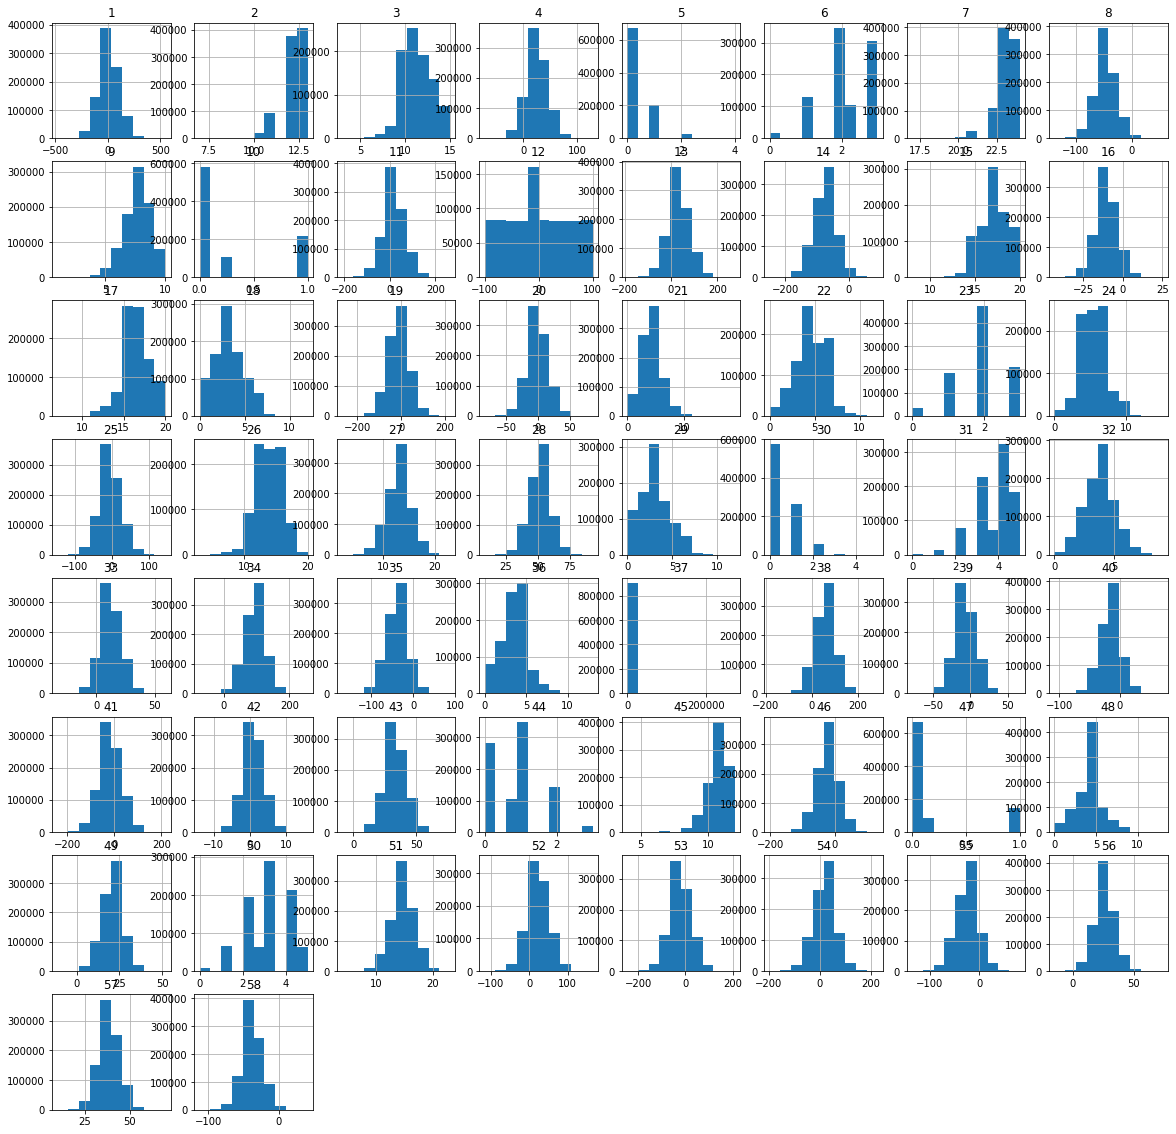

In [15]:
plt.figure(figsize=(20,20))
for i in range(0,58):
    plt.subplot(8,8,i+1)
    plt.title(X.columns[i])
    X.iloc[:,i].hist()

### Data Scaling

In [18]:
X = StandardScaler().fit_transform(X)

i=1
features = []
for i in range(1,59):
    str(i)
    features.append(i)

pd.DataFrame(X, columns=features).head()

,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
0,-5.638929e-01,4.703933e-15,0.410460,1.238396e-14,1.339988,-0.248943,9.557818e-01,0.068418,-3.572334e-15,1.754344,...,-4.498439e-01,0.962061,0.147188,-0.077243,1.312168e-01,-0.435467,0.928792,-0.649745,2.703742,1.381513
1,-2.565334e-01,8.874649e-01,0.410460,2.512101e+00,-0.611824,-0.248943,9.557818e-01,-0.155586,-7.252292e-01,-0.646074,...,1.510293e-01,-0.928376,-0.775478,-0.954134,9.055558e-01,-0.256421,-0.205299,-0.352922,1.631657,-0.722326
2,4.262078e-01,8.874649e-01,0.410460,1.922387e+00,-0.611824,1.129114,9.557818e-01,-0.667105,7.918890e-02,-0.646074,...,-2.697877e-14,0.016843,0.608521,-0.077659,1.309311e-14,-0.209612,0.604405,1.019915,-0.664961,0.258762
3,4.465529e-15,-4.365747e-01,1.036213,-2.066140e+00,1.339988,-1.627001,-2.731521e-01,2.510067,8.836070e-01,-0.646074,...,-5.994695e-01,-0.928376,0.147188,-1.742588,-1.668991e-01,0.879968,1.625101,0.361367,0.331526,0.082622
4,-3.539569e-02,4.703933e-15,1.036213,1.740693e+00,-0.611824,1.129114,-8.732100e-15,-0.807147,-3.572334e-15,-0.646074,...,-2.002313e+00,0.962061,-0.314145,0.232732,8.014383e-02,0.509724,-1.789421,0.965460,2.064360,-0.491623


In [14]:
# # Transform to normal distribution
# features = X.columns.tolist()
    
# for i in cols:
#     X[i] = (X[i]-X[i].mean())/X[i].std()
    
# pd.DataFrame(X, columns=features).head()

In [19]:
Y = pd.DataFrame(y)
Y.rename(columns={0: 'target'}, inplace=True)
data = pd.concat((pd.DataFrame(X, columns=features), Y), axis = 1)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
y = np.ravel(y)

Check the distribution of decision variable

In [20]:
pd.value_counts(Y['target'].values, sort=False)

0    623940
1    276060
dtype: int64

### Data Spliting

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)